# Reuse resources for multiple decoding or encoding operations

Memory allocations can sometimes be a significant bottleneck, especially when processing many images in sequence. By allocating memory once and reusing it for multiple decoding or encoding operations, you can greatly improve performance and reduce overhead.

The following examples demonstrate how to pre-allocate resources such as `Image` buffers or `CodeStream` objects, and efficiently reuse them for repeated operations. This approach is particularly useful in high-throughput or real-time applications where minimizing latency is critical.

Firstly, import nvImageCodec and necessary modules

In [1]:
from nvidia import nvimgcodec
from matplotlib import pyplot as plt
import os
import numpy as np

Set resource directory path

In [2]:
resources_dir = os.getenv("PYNVIMGCODEC_EXAMPLES_RESOURCES_DIR", "../assets/images/")

## Reusing Image for multiple decoding operations

Create an decoder

In [3]:
decoder = nvimgcodec.Decoder()

In [4]:
img_full_path_1 = os.path.abspath(os.path.join(resources_dir, "tabby_tiger_cat.jpg"))
img_full_path_2 = os.path.abspath(os.path.join(resources_dir, "cat-1046544_640.jp2"))

Decode first image

In [5]:
nv_image = decoder.read(img_full_path_1)
print("First image decoded")
print(f"  shape: {nv_image.shape}")
print(f"  dtype: {nv_image.dtype}")
print(f"  size: {nv_image.size}")
print(f"  capacity: {nv_image.capacity}")
print(f"  buffer_kind: {nv_image.buffer_kind}")


First image decoded
  shape: (720, 720, 3)
  dtype: uint8
  size: 1555200
  capacity: 1555200
  buffer_kind: ImageBufferKind.STRIDED_DEVICE


Lets display it to verify

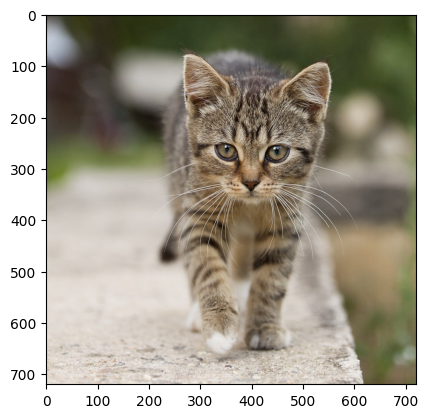

In [6]:
plt.imshow(nv_image.cpu())

Now decode another file but to the same Image

In [7]:
nv_image = decoder.read(img_full_path_2, image=nv_image)
print("Second image decoded")
print(f"  shape: {nv_image.shape}")
print(f"  dtype: {nv_image.dtype}")
print(f"  size: {nv_image.size}")
print(f"  capacity: {nv_image.capacity}")
print(f"  buffer_kind: {nv_image.buffer_kind}")
print("Please note that the image is reused, and the size is from the second image but as it is smaller, the capacity did not change.")

Second image decoded
  shape: (475, 640, 3)
  dtype: uint8
  size: 912000
  capacity: 1555200
  buffer_kind: ImageBufferKind.STRIDED_DEVICE
Please note that the image is reused, and the size is from the second image but as it is smaller, the capacity did not change.


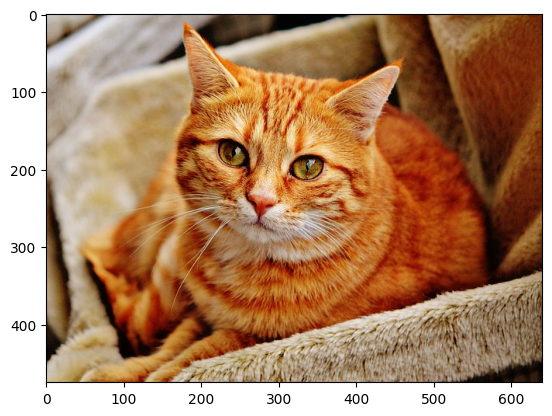

In [8]:
plt.imshow(nv_image.cpu())

There is possibility to reuse more Images for batch decoding

In [9]:
# Define multiple image paths
img_paths_1 = [
    os.path.join(resources_dir, "Weimaraner.bmp"),
    os.path.join(resources_dir, "tabby_tiger_cat.jpg"),
]

# Create CodeStream objects for batch processing
code_streams_1 = [nvimgcodec.CodeStream(path) for path in img_paths_1]

print("Created code streams for batch processing:")
for i, cs in enumerate(code_streams_1):
    print(f"  Stream {i+1}: {cs.width}x{cs.height}, codec: {cs.codec_name}")


Created code streams for batch processing:
  Stream 1: 720x720, codec: bmp
  Stream 2: 720x720, codec: jpeg


First, decode batch normally (allocating new images each time)

Image 1: (720, 720, 3), dtype: uint8, size: 1555200, capacity: 1555200, buffer_kind: ImageBufferKind.STRIDED_DEVICE
Image 2: (720, 720, 3), dtype: uint8, size: 1555200, capacity: 1555200, buffer_kind: ImageBufferKind.STRIDED_DEVICE


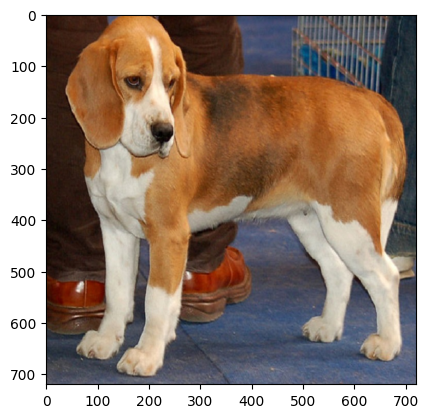

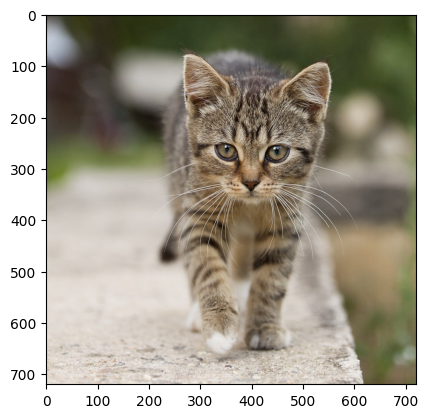

In [10]:
imgs_normal = decoder.decode(code_streams_1)

for i, img in enumerate(imgs_normal):
    print(f"Image {i+1}: {img.shape}, dtype: {img.dtype}, size: {img.size}, capacity: {img.capacity}, buffer_kind: {img.buffer_kind}")
    plt.figure()
    plt.imshow(img.cpu())


Now reuse the Image objects for decoding the other streams

In [11]:
# Define multiple image paths
img_paths_2 = [
    os.path.join(resources_dir, "cat-1046544_640.jp2"),
    os.path.join(resources_dir, "Alex_2016-01-14_1300Z_(Geotiff).tif"),
]

# Create CodeStream objects for batch processing
code_streams_2 = [nvimgcodec.CodeStream(path) for path in img_paths_2]

print("Created code streams for batch processing:")
for i, cs in enumerate(code_streams_2):
    print(f"  Stream {i+1}: {cs.width}x{cs.height}, codec: {cs.codec_name}")


Created code streams for batch processing:
  Stream 1: 640x475, codec: jpeg2k
  Stream 2: 5000x6400, codec: tiff


Image 1: (475, 640, 3), dtype: uint8, size: 912000, capacity: 1555200, buffer_kind: ImageBufferKind.STRIDED_DEVICE, Same object reused = True
Image 2: (6400, 5000, 3), dtype: uint8, size: 96000000, capacity: 96000000, buffer_kind: ImageBufferKind.STRIDED_DEVICE, Same object reused = True
-------------------------
Please note that both images are reused.
For both images the sizes are from the second decoding.
For first image the capacity is the same as from the first decoding as image is smaller, so no reallocation was needed.
For second image the capacity had to grow as image is larger, so reallocation was needed.


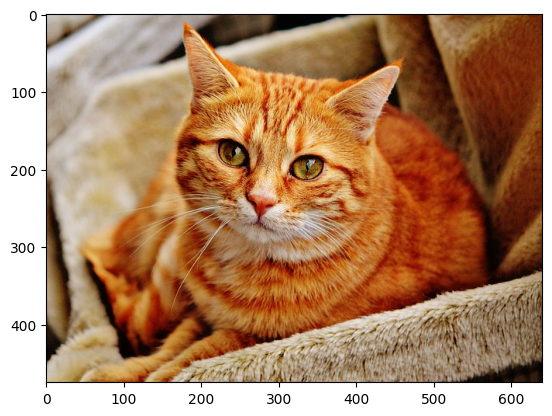

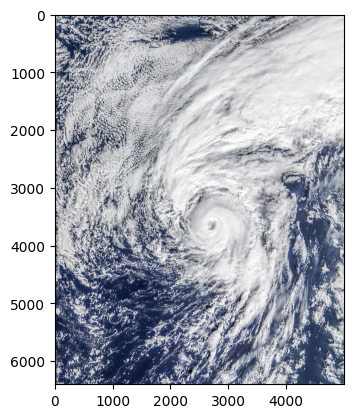

In [12]:
imgs_reused = decoder.decode(code_streams_2, images=imgs_normal)

for i, (img_normal, img_reused) in enumerate(zip(imgs_normal, imgs_reused)):
    is_same_object = img_reused is img_normal
    print(f"Image {i+1}: {img_reused.shape}, dtype: {img_reused.dtype}, size: {img_reused.size}, capacity: {img_reused.capacity}, buffer_kind: {img_reused.buffer_kind}, Same object reused = {is_same_object}")

    plt.figure()
    plt.imshow(img_reused.cpu())

print("-"*25 + "\n" + "Please note that both images are reused.\n"
      "For both images the sizes are from the second decoding.\n"
      "For first image the capacity is the same as from the first decoding as image is smaller, so no reallocation was needed.\n"
      "For second image the capacity had to grow as image is larger, so reallocation was needed.")

## Reusing CodeStream for multiple encoding operations

Create an encoder

In [13]:
encoder = nvimgcodec.Encoder()

Create and encode the first image:

In [14]:
# Create first image
img1 = np.random.randint(0, 255, (2160, 3840, 3), dtype=np.uint8)


# Encode the first image 
code_stream = encoder.encode(img1, codec="jpeg2k")
print("First encoding:")
print("  size:", code_stream.size)
print("  capacity:", code_stream.capacity)
print("  codec:", code_stream.codec_name)
print("  shape:", code_stream.height, "x", code_stream.width)


First encoding:
  size: 22837215
  capacity: 22837215
  codec: jpeg2k
  shape: 2160 x 3840


Now create another image and encode it by reusing the code stream created earlier. With this approach, we save time by avoiding memory reallocation for another code_stream:

In [15]:
#create second image
img2 = np.random.randint(0, 255, (2160, 3840, 3), dtype=np.uint8)

# Reuse the same CodeStream for a second image (possibly with a different codec)
code_stream = encoder.encode(img2, codec="jpeg2k", code_stream_s = code_stream)
print("Second encoding:")
print("  size:", code_stream.size)
print("  capacity:", code_stream.capacity)
print("  codec:", code_stream.codec_name)
print("  shape:", code_stream.height, "x", code_stream.width)

Second encoding:
  size: 22836324
  capacity: 22837215
  codec: jpeg2k
  shape: 2160 x 3840


We can preallocate a CodeStream and specify that it should pin memory, making transfers between Host and Device faster:

In [16]:
code_stream = nvimgcodec.CodeStream(24*1024*1024, pin_memory=True)

Encode the first image using the preallocated code stream. This will use the existing preallocated code stream instead of allocating a new one:

In [17]:

code_stream = encoder.encode(img1, codec="jpeg2k", code_stream_s=code_stream)
print("First encoding:")
print("  size:", code_stream.size)
print("  capacity:", code_stream.capacity)
print("  codec:", code_stream.codec_name)
print("  shape:", code_stream.height, "x", code_stream.width)


First encoding:
  size: 22837215
  capacity: 25165824
  codec: jpeg2k
  shape: 2160 x 3840


If there is not enough space in the preallocated code stream, it will be automatically resized to fit the new image and the capacity will be updated:

In [18]:
img3 = np.random.randint(0, 255, (2*2160, 2*3840, 3), dtype=np.uint8)

code_stream = encoder.encode(img3, codec="jpeg2k", code_stream_s = code_stream)
print("Third encoding:")
print("  size:", code_stream.size)
print("  capacity:", code_stream.capacity)
print("  codec:", code_stream.codec_name)
print("  shape:", code_stream.height, "x", code_stream.width)

Third encoding:
  size: 91338495
  capacity: 91338495
  codec: jpeg2k
  shape: 4320 x 7680


## Reusing externally managed buffers (from CuPy or NumPy)

The example below will show how to use buffer created by CuPy, but it will work the same way for buffer from NumPy.

Create buffer that will be used for decoding and cast it to nvImageCodec Image

In [19]:
import cupy as cp

buffer = cp.zeros((800, 800, 3), dtype=np.uint8)
buffer_image = nvimgcodec.as_image(buffer)

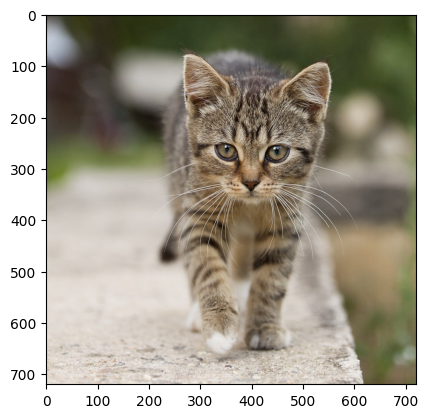

In [20]:
decoded_image = decoder.decode(img_full_path_1, image=buffer_image)

assert decoded_image is buffer_image # nvImageCodec will decode to passed buffer

plt.imshow(decoded_image.cpu())

One can also inspect original buffer

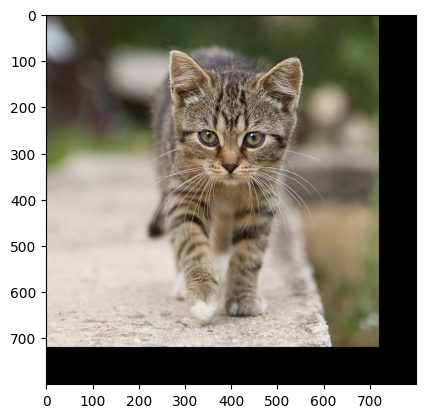

In [21]:
plt.imshow(cp.asnumpy(buffer))

The buffer that is reused may contain padding

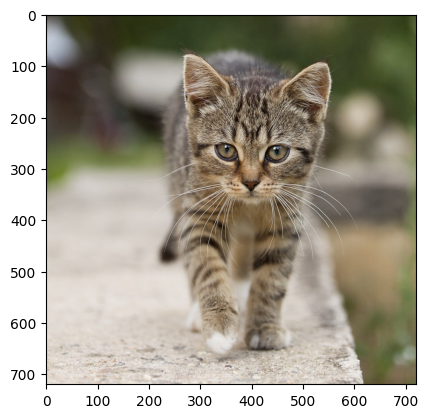

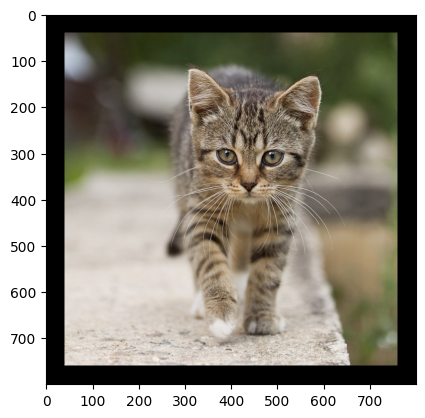

In [22]:
buffer[:] = 0 #clear the buffer
slice = buffer[40:-40, 40:-40] # create slice with row padding

buffer_image = nvimgcodec.as_image(slice)

decoded_image = decoder.decode(img_full_path_1, image=buffer_image)

plt.figure()
plt.imshow(decoded_image.cpu())

plt.figure()
plt.imshow(cp.asnumpy(buffer))

Decoding ROI to externally managed buffer is also allowed

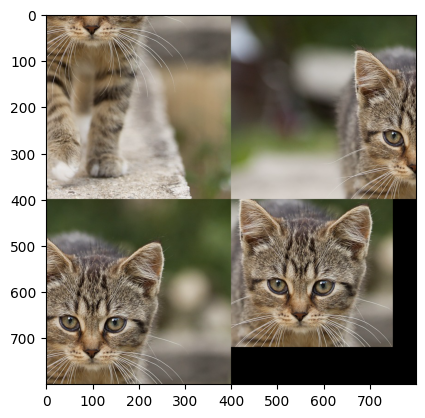

In [23]:
buffer[:] = 0 #clear the buffer

code_stream = nvimgcodec.CodeStream(img_full_path_1)

image_buffers = []
code_streams = []

# divide original buffer into 4 equal parts
image_buffers.append(nvimgcodec.as_image(buffer[:400, :400]))
image_buffers.append(nvimgcodec.as_image(buffer[:400, 400:]))
image_buffers.append(nvimgcodec.as_image(buffer[400:, :400]))
image_buffers.append(nvimgcodec.as_image(buffer[400:, 400:]))

# select four regions to decode
code_streams.append(code_stream.get_sub_code_stream(region=nvimgcodec.Region(start=(300, 300), end=(700, 700))))
code_streams.append(code_stream.get_sub_code_stream(region=nvimgcodec.Region(start=(0, 0), end=(400, 400))))
code_streams.append(code_stream.get_sub_code_stream(region=nvimgcodec.Region(start=(0, 300), end=(400, 700))))
code_streams.append(code_stream.get_sub_code_stream(region=nvimgcodec.Region(start=(80, 250), end=(400, 600)))) # region can be smaller than buffer slice


decoded_image = decoder.decode(code_streams, images=image_buffers) # Note that for batched decode, buffer parameter is `images` not `image`

plt.imshow(cp.asnumpy(buffer))

If buffer is continuous, nvimagecodec can reshape it

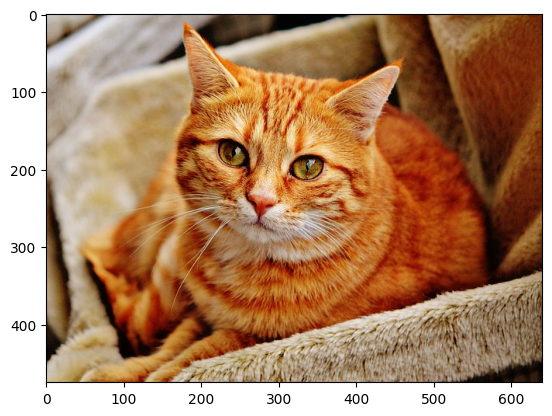

In [24]:
buffer = cp.zeros((100, 4000, 3), dtype=np.uint8)
buffer_image = nvimgcodec.as_image(buffer)

decoded_image = decoder.decode(img_full_path_2, image=buffer_image)

assert decoded_image is buffer_image # nvImageCodec will decode to passed buffer

plt.imshow(decoded_image.cpu())

The image is still decoded into original buffer

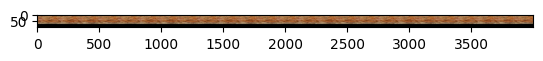

In [25]:
plt.imshow(cp.asnumpy(buffer))

But to see the image we would need to reshape original buffer manually

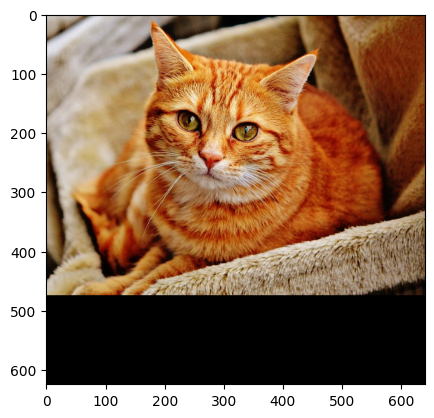

In [26]:
target_shape = (-1, decoded_image.shape[1], decoded_image.shape[2]) # height is -1, because original buffer is larger than needed and nvImageCodec will only use prefix of this buffer
buffer_view = cp.reshape(buffer, target_shape)
plt.imshow(cp.asnumpy(buffer_view))

If buffer is too small, decoding will throw an error:

In [27]:
buffer = cp.zeros((100, 4000, 3), dtype=np.uint8)
buffer_image = nvimgcodec.as_image(buffer)

try:
    decoded_image = decoder.decode(img_full_path_1, image=buffer_image)
except Exception as e:
    print(e)

Existing buffer is too small to fit new image


If buffer is not continuous, reshape cannot be made. The dimensions of image must be smaller than buffer size

In [28]:
buffer = cp.zeros((100, 4000, 3), dtype=np.uint8)
slice = buffer[10:-10, 10:-10] # make buffer not continous
buffer_image = nvimgcodec.as_image(slice)

try:
    decoded_image = decoder.decode(img_full_path_1, image=buffer_image)
except Exception as e:
    print(e)

Existing buffer is not continuous. Row size or height are too small to fit new image.
